In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from sklearn.preprocessing import StandardScaler
%matplotlib inline


<h3>Reading the data</h3>

In [2]:
df = pd.read_csv(r'C:\Users\moham\Desktop\thesis\thesis\data\data.csv').drop(['name', 'year'], axis=1)


<h3>Reading the data</h3>
<ul>
    <li>Shape :(108631, 48)| Positive cases = 1650(0.01% of total cases)| Negative cases = 106506  </li>
    <li>Outliers : Total : 29099   |   positive cases : 624(38% of total neg. cases)| negetive cases : 28308 </li>
    <li>Missing values : 1471 samples </li>
</ul>

In [3]:
#------Shape---------#
shape = df.shape #(108631, 48)
positiveCases = (df['pH']<7.05).sum()
negativeCases = (df['pH']>7.05).sum()

In [4]:
print('Positive Cases : %d' % positiveCases)
print('Negative Cases : %d' % negativeCases)

Positive Cases : 1650
Negative Cases : 106506


In [5]:
#--Columns and their types--#
df.dtypes;

In [6]:
def data_outliers(df):
    """
    Standarizing the data and any sample that has a value outside of the 3rd standard deviation
    is considered an outlier 
    
    Parameters
    ----------
    df : Pandas Dataframe
    
    Output
    ----------
    list : list of int. numbers indicating the indices of the outliers in the df
    """
    #standarizing
    sc = StandardScaler()
    sc.fit(df)
    df = pd.DataFrame(sc.transform(df))
    df = df[df<3] #Outside of the 3rd standard deviation 
    outliers_index = df[df.isnull().any(axis=1)].index.tolist()
    return outliers_index
outliers = data_outliers(df)
positiveOutliers = (df.iloc[outliers]['pH']<7.05).sum()
negativeOutliers = (df.iloc[outliers]['pH']>7.05).sum()
totalOutliers = len(outliers)
print('Total Outliers : %d, Positive Outliers : %d, Negative Outliers : %d' % (totalOutliers, positiveOutliers, negativeOutliers))

C:\Users\moham\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\moham\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


Total Outliers : 29099, Positive Outliers : 624, Negative Outliers : 28308


In [7]:
df = df.dropna() #To be treated later

In [8]:
df.shape #Without missing values

(105035, 48)

<h3> First Stage: </h3

In [9]:
# Getting samples from the first stage only
ind = np.logical_and(df.segStageI_index > 0, df.segStageI_index <= 1) 
df = df.loc[ind, :]


####  1) Visualizing every feature with the target

In [10]:
df['diagnosis'] = (df.pH <= 7.05).astype(int).ravel() # to help with the hue 

In [11]:
# y = df.pH
# hue = df.diagnosis
# for i in range(len(df.columns)):
#     plt.figure(figsize=(8, 3))
#     fig = sns.scatterplot(x=df[df.columns[i]], y=y, data=df, hue=hue) 

#### 2) Box plots

In [12]:
# for i in range(1, len(df.columns)):
#     plt.figure(figsize=(8, 3))
#     sns.set(style="whitegrid")
#     ax = sns.boxplot(x=df[df.columns[i]])
   

####  2) Corr. Matrix

In [13]:
#______________ENCODING THE PH COLUMN____________________
# 0: healthy, 1: positive(acidosis)
df = df.drop(['diagnosis'], axis=1)
df['pH'] = (df.pH <= 7.05).astype(int).ravel()
df.shape #--> (3404, 48)

(4462, 48)

In [14]:
positiveCases = (df['pH']==1).sum();positiveCases # 86 positive cases out of 4462


86

In [15]:
df = df.drop(['segStage'], axis=1) # all are taken from the same stage (1st stage)

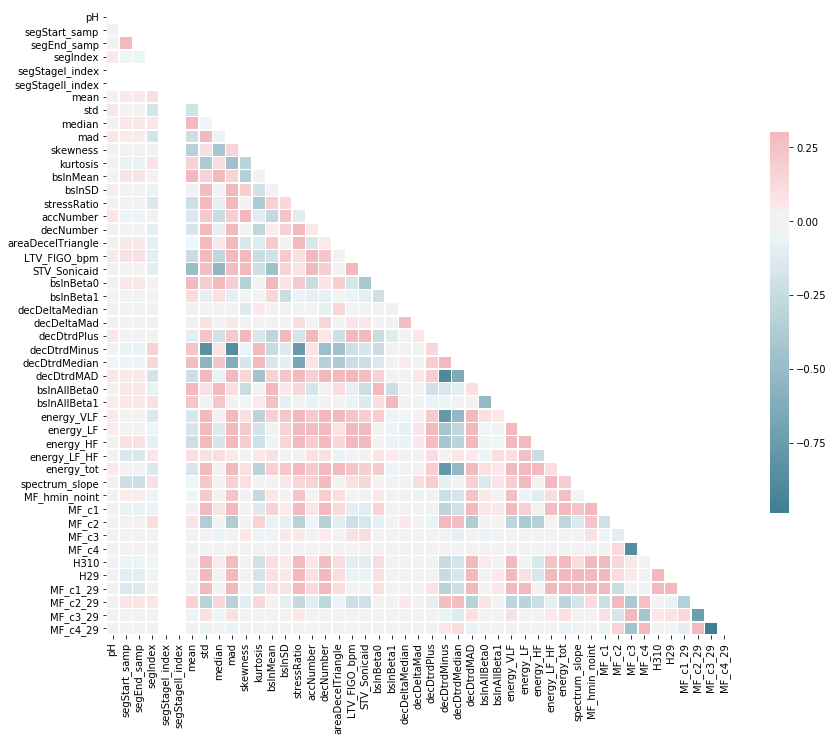

In [16]:

corr = df.corr()
def plot_corr(corr):
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    f, ax = plt.subplots(figsize=(14, 14))
    
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5})
plot_corr(corr)

<h3>Logistic Regression</h3>

In [17]:
y = df['pH'] # target
X = df.drop(['pH'], axis=1) # Feature matrix


In [18]:
X.head()

,segStart_samp,segEnd_samp,segIndex,segStageI_index,segStageII_index,mean,std,median,mad,skewness,...,MF_c1,MF_c2,MF_c3,MF_c4,H310,H29,MF_c1_29,MF_c2_29,MF_c3_29,MF_c4_29
13,15601,20400,3,1,0,136.043207,34.244851,144.25,30.625562,-0.299440,...,1.541740,-0.320374,-0.072248,0.443586,0.251573,0.322433,1.561143,-0.237683,-0.072733,0.186351
46,36001,40800,3,1,0,147.072604,12.863330,145.75,10.407536,0.036986,...,1.526265,-0.002046,0.006373,-0.061292,0.476296,0.525474,1.561249,0.009067,-0.000521,-0.062645
64,18001,22800,6,1,0,129.858446,16.675711,134.00,12.348971,-0.756702,...,1.513655,-0.025695,-0.036561,-0.142221,0.432595,0.460897,1.525905,-0.010476,-0.034858,-0.138176
78,9601,14400,5,1,0,117.748872,19.359356,119.25,12.142754,-0.357331,...,1.599210,-0.260384,-0.234299,-0.055279,0.189094,0.298341,1.623602,-0.222504,-0.128656,-0.089185
90,8401,13200,3,1,0,140.781758,7.376388,141.50,5.412613,-1.310544,...,1.415286,-0.116083,-0.014288,-0.030838,0.254531,0.358241,1.486842,-0.096960,0.032126,-0.189776


In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [20]:
#standarizing the training data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)
columns = list(X_train)
X_train = pd.DataFrame(sc.transform(X_train))
X_train.columns = columns


C:\Users\moham\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\moham\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


In [21]:
from sklearn.linear_model import LogisticRegression
lr_rigid = LogisticRegression(solver='lbfgs', penalty='l2', random_state=1)
lr_lasso = LogisticRegression(penalty='l1', random_state=1)
lr_rigid.fit(X_train, y_train)
lr_lasso.fit(X_train, y_train)

C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=1, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [22]:
X_test = sc.transform(X_test)
y_pred_class_rigid = lr_rigid.predict(X_test)
y_pred_class_lasso = lr_lasso.predict(X_test)


C:\Users\moham\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


<h4>Performance : </h4>

In [23]:
from sklearn import metrics
# For L1 penalty 
print(metrics.accuracy_score(y_test, y_pred_class_rigid))

0.9798356982823002


In [24]:
# For L2 penalty
print(metrics.accuracy_score(y_test, y_pred_class_lasso))

0.9798356982823002


In [25]:
# For L2 penalty
confusion_l2 = metrics.confusion_matrix(y_test, y_pred_class_rigid);confusion_l2

array([[1312,    1],
       [  26,    0]], dtype=int64)

In [26]:
# For L1 penalty
confusion_l1 = metrics.confusion_matrix(y_test, y_pred_class_lasso);confusion_l1

array([[1312,    1],
       [  26,    0]], dtype=int64)

<h4>ROC AND AUC </h4>

In [27]:
y_proba_l2 = lr_rigid.predict_proba(X_test)[:, 1]
y_proba_l1= lr_lasso.predict_proba(X_test)[:, 1]
fpr_l2, tpr_l2, threshold_l2 = metrics.roc_curve(y_test, y_proba_l2)
fpr_l1, tpr_l1, threshold_l1 = metrics.roc_curve(y_test, y_proba_l1)

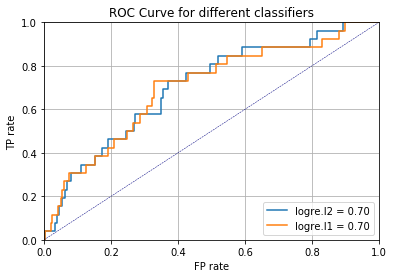

In [28]:
plt.plot(fpr_l2, tpr_l2, label='logre.l2 = %0.2f' % metrics.auc(fpr_l2, tpr_l2))
plt.plot(fpr_l1, tpr_l1, label='logre.l1 = %0.2f' % metrics.auc(fpr_l1, tpr_l1))
plt.plot([0, 1], [0, 1], color='navy', lw=0.5, linestyle='--')
plt.legend(loc = 'lower right')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC Curve for different classifiers')
plt.xlabel('FP rate')
plt.ylabel('TP rate')
plt.grid(True)



In [29]:
def plot_regularization(X_train, columns):
    """
    ploting the strength of the regularization parameter C vs the weights
    
    Parameters
    ----------
    X_train : Pandas Dataframe, training dataset
    
    Output
    ----------
    plot : C vs weights
"""
    
    weights, params = [], []
    columns = X_train.columns
    for c in np.arange(-5, 5):
        lr = LogisticRegression(solver='lbfgs', C=10.**c, random_state=1)
        lr.fit(X_train, y_train)
        weights.append(lr.coef_[0])
        params.append(10.**c)
    weights = np.array(weights)
    plt.figure(figsize=(18,15))
    for i in range(len(columns)):
        plt.plot(params, weights[:, i], label=columns[i])
    plt.ylabel('weight coefficient')
    plt.xlabel('C')
    plt.legend(loc='upper left')
    plt.xscale('log')
    plt.grid(True)
    plt.show()

C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


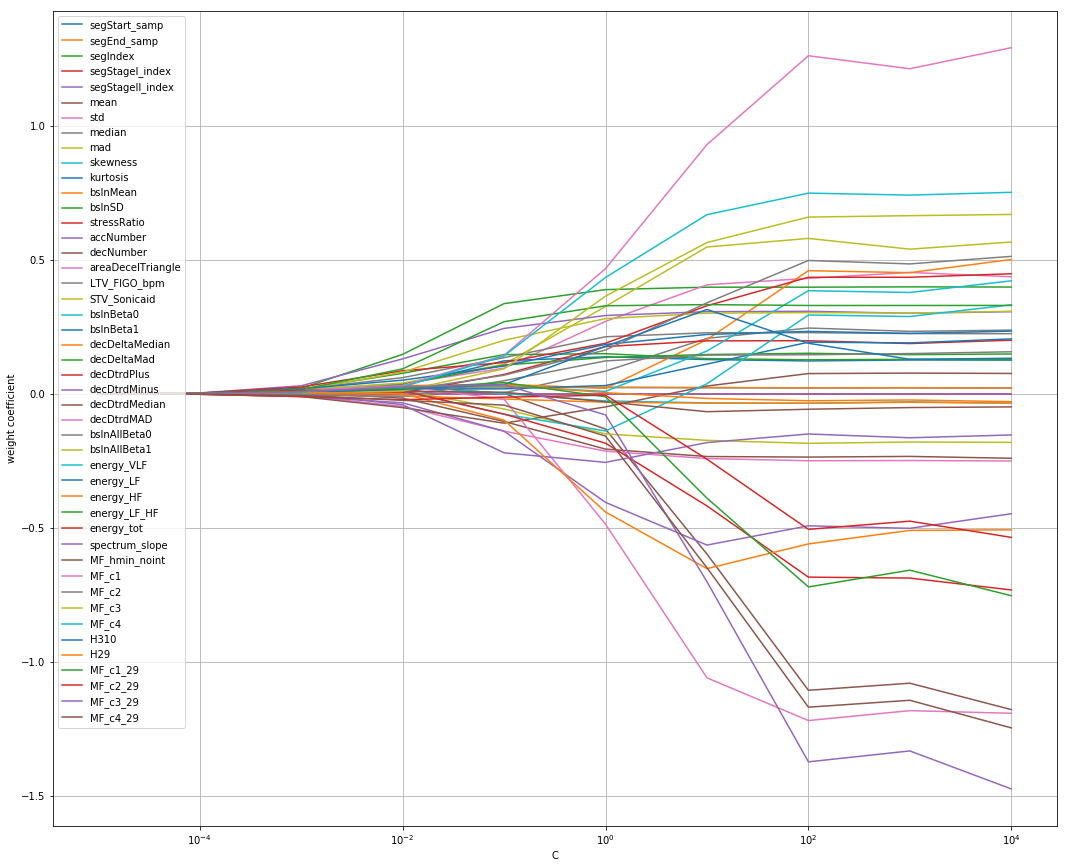

In [30]:
plot_regularization(X_train, X_train.columns)